In [ ]:
# Install necessary libraries
!pip install torch_geometric torch_scatter torch_sparse
!pip install librosa scikit-learn matplotlib

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Libraries
import os
import librosa
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Load RAVDESS Dataset (Audio Emotion Data)
RAVDESS_DIR = '/content/drive/MyDrive/RAVDESS Emotional speech audio'

In [ ]:
def load_ravdess_data(data_dir):
    labels = []
    features = []

    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                audio, sample_rate = librosa.load(file_path, sr=None)
                mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                features.append(np.mean(mfccs.T, axis=0))

                # Extract emotion from the file name
                emotion = int(file.split('-')[2]) - 1  # RAVDESS labels emotion from 1-8
                labels.append(emotion)

    return np.array(features), np.array(labels)

In [ ]:

# Load data
X, y = load_ravdess_data(RAVDESS_DIR)

In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
def create_graph_data(X, y):
    data_list = []
    for i in range(len(X)):
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Single-node graph for each sample
        features = torch.tensor([X[i]], dtype=torch.float)
        label = torch.tensor([y[i]], dtype=torch.long)
        data = Data(x=features, edge_index=edge_index, y=label)
        data_list.append(data)
    return data_list


In [ ]:
train_data_list = create_graph_data(X_train, y_train)
test_data_list = create_graph_data(X_test, y_test)

from torch_geometric.loader import DataLoader

# DataLoader
train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32)


<ipython-input-87-aad3ecd1feb4>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  features = torch.tensor([X[i]], dtype=torch.float)


In [ ]:
from torch_geometric.nn import global_mean_pool


In [ ]:
# GNN Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, data.batch)  # Batch-wise global mean pooling
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

In [ ]:
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_train))
model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
import torch.nn as nn


In [ ]:
# Define loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Experiment with learning rate

In [ ]:
# Implement learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
def train_model(model, loader, optimizer, loss_fn, scheduler=None, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()

            # Forward pass
            out = model(batch)  # Output is per graph

            # Loss calculation (per graph label)
            loss = loss_fn(out, batch.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if scheduler:
            scheduler.step()  # Adjust learning rate

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Train the model with updated function
train_model(model, train_loader, optimizer, loss_fn, scheduler, epochs=100)

Epoch 1/100, Loss: 38.5693
Epoch 11/100, Loss: 21.1775
Epoch 21/100, Loss: 17.3269
Epoch 31/100, Loss: 15.8839
Epoch 41/100, Loss: 15.1241
Epoch 51/100, Loss: 14.7601
Epoch 61/100, Loss: 14.5605
Epoch 71/100, Loss: 14.3976
Epoch 81/100, Loss: 14.3573
Epoch 91/100, Loss: 14.3829


In [ ]:
# Evaluation
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            out = model(batch)
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    accuracy = correct / len(all_labels)
    print(f"Accuracy: {accuracy:.4f}")

    return all_labels, all_preds

In [ ]:
# Evaluate the model
y_true, y_pred = evaluate_model(model, test_loader)

Accuracy: 0.8455


In [ ]:
# Ensure the target names are strings
target_names = [str(label) for label in label_encoder.classes_]

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        43
           1       0.70      0.77      0.73        66
           2       0.93      0.87      0.90        71
           3       0.83      0.85      0.84        86
           4       0.92      0.90      0.91        81
           5       0.84      0.89      0.86        72
           6       0.92      0.85      0.88        71
           7       0.99      0.84      0.91        86

    accuracy                           0.85       576
   macro avg       0.84      0.84      0.84       576
weighted avg       0.86      0.85      0.85       576



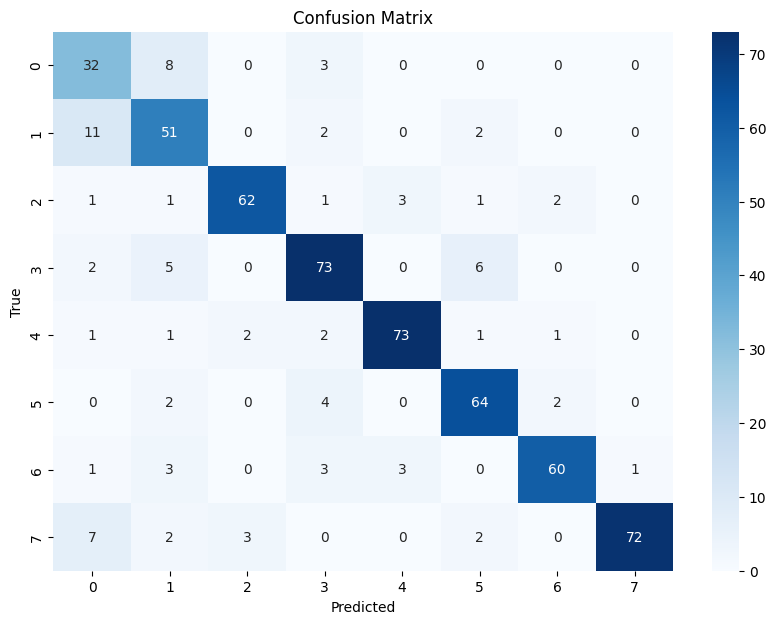

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()